## find out how many bicycles need to be ready at a given time in the Washington, D.C. market.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error




plt.rcParams['figure.figsize'] = (12,6)

## Loading the Data


In [77]:
df = pd.read_csv('train.csv', parse_dates = True)

## Dropping out casula and registered

df=df.drop(['casual'], axis=1)
df=df.drop(['registered'], axis=1)

## Extracting Time data

ts = pd.to_datetime(df['datetime'])
df['year']= ts.dt.year
df['month']= ts.dt.month
df['day']= ts.dt.day
df['hour']=ts.dt.hour
df['day_name']=ts.dt.day_name()



### As a lot of values are 0 in windspeed we can consider the following scenerios:¶


In [3]:
df[df['windspeed'] == 0].shape


(1313, 15)

In [4]:
## filling up the zero values via Random Forest

df_windspeed_0 = df[df['windspeed'] == 0]
df_windspeed_not_0 = df[df['windspeed'] != 0]

columns_for_windspeed = ['holiday', 'season', 'workingday', 'month', 'hour', 'year', 'day', 'temp', 'humidity']


In [5]:


from sklearn.ensemble import RandomForestRegressor
rf_windspeed = RandomForestRegressor().fit(df_windspeed_not_0[columns_for_windspeed], df_windspeed_not_0['windspeed'])
df_windspeed_0['windspeed'] = rf_windspeed.predict(df_windspeed_0[columns_for_windspeed])

df = df_windspeed_0.append(df_windspeed_not_0, sort = 'datetime')

/home/aprameyo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
df[df['windspeed'] == 0].shape


(0, 15)

In [7]:
## Filling up the humidity values via median 

df[df['humidity'] == 0].shape


(22, 15)

In [8]:
df['humidity'] =  np.where(df['humidity']==0, df['humidity'].median(), df['humidity'])


In [9]:
df[df['humidity'] == 0].shape


(0, 15)

## Data exploration via plotting the Data


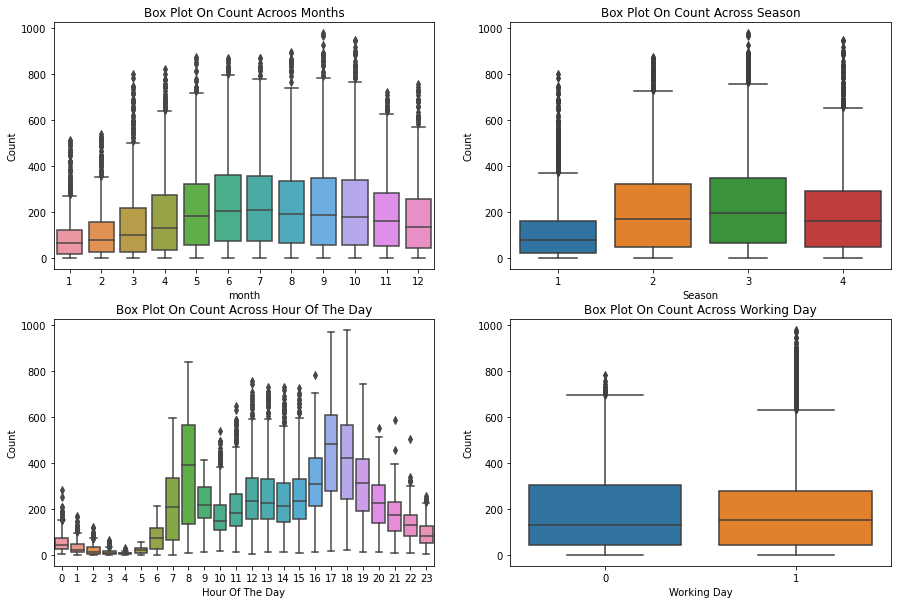

In [10]:
import matplotlib.pyplot as plt



fig, axes = plt.subplots(nrows=2,ncols=2)

fig.set_size_inches(15, 10)

sns.boxplot(data=df,y="count",x= "month", orient="v",ax=axes[0][0])
sns.boxplot(data=df,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=df,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=df,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count Acroos Months")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

plt.show()
fig.savefig("output1.png")


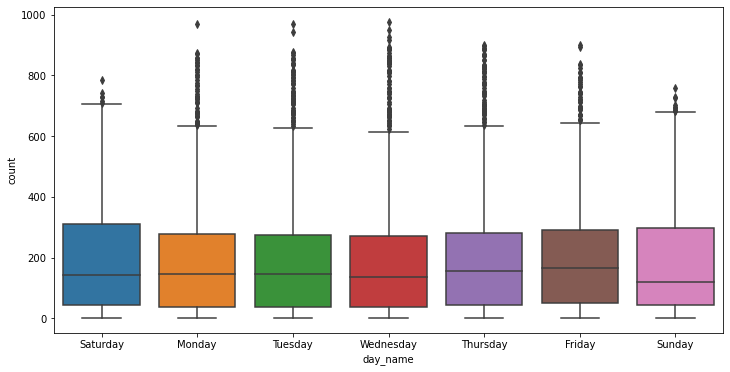

In [11]:
fig2 = sns.boxplot(data=df,y="count",x= "day_name", orient="v")



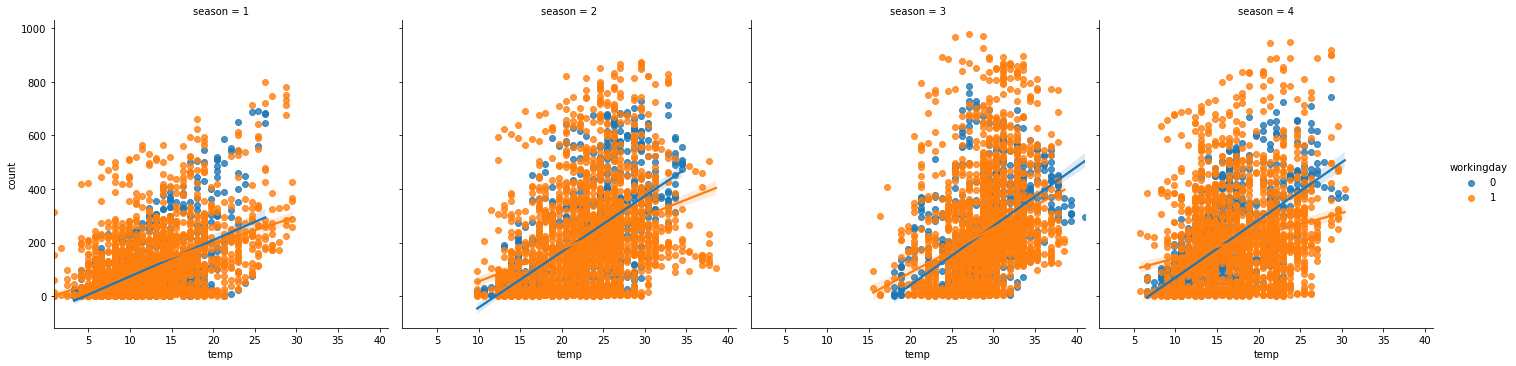

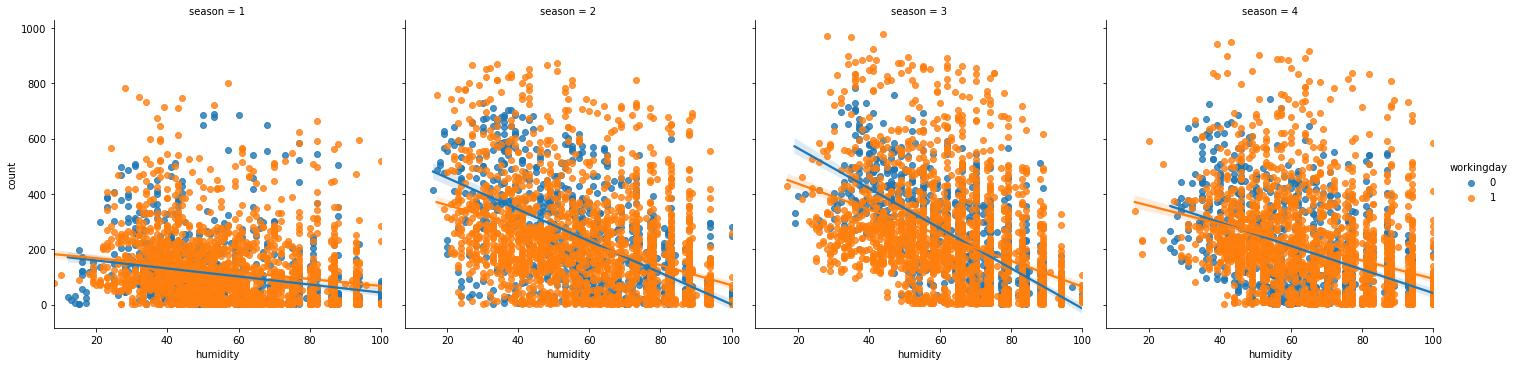

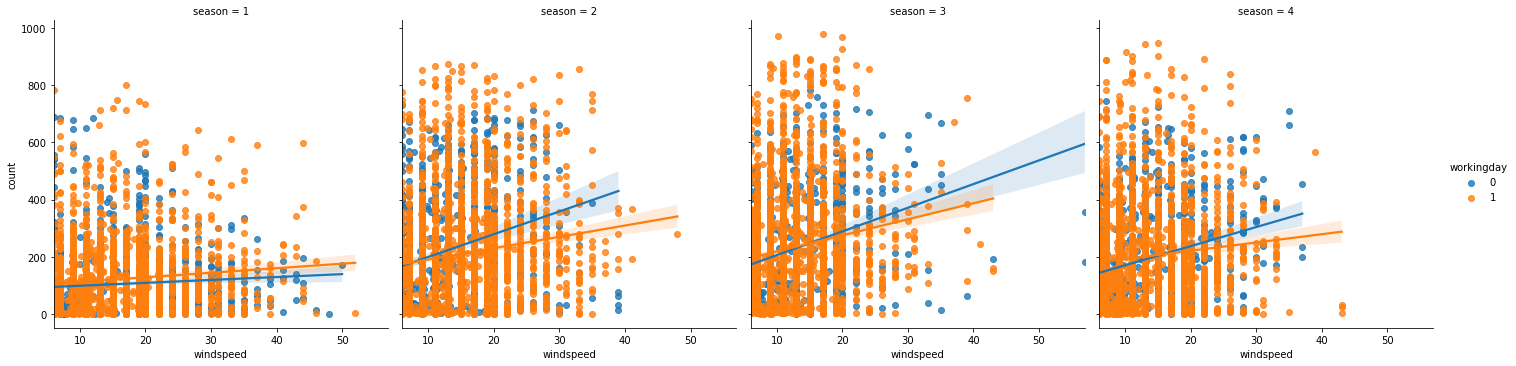

In [12]:
import matplotlib.pyplot as plt



#fig, axes = plt.subplots(nrows=2,ncols=2)

fig.set_size_inches(15, 10)
sns.lmplot(x='temp', y='count', col='season', data=df, hue='workingday')
sns.lmplot(x='humidity', y='count', col='season', data=df, hue='workingday')
sns.lmplot(x='windspeed', y='count', col='season', data=df, hue='workingday')
#sns.lmplot(x='month', y='count', col='season', data=df, hue='workingday')



plt.show()
fig.savefig('Output2.png')

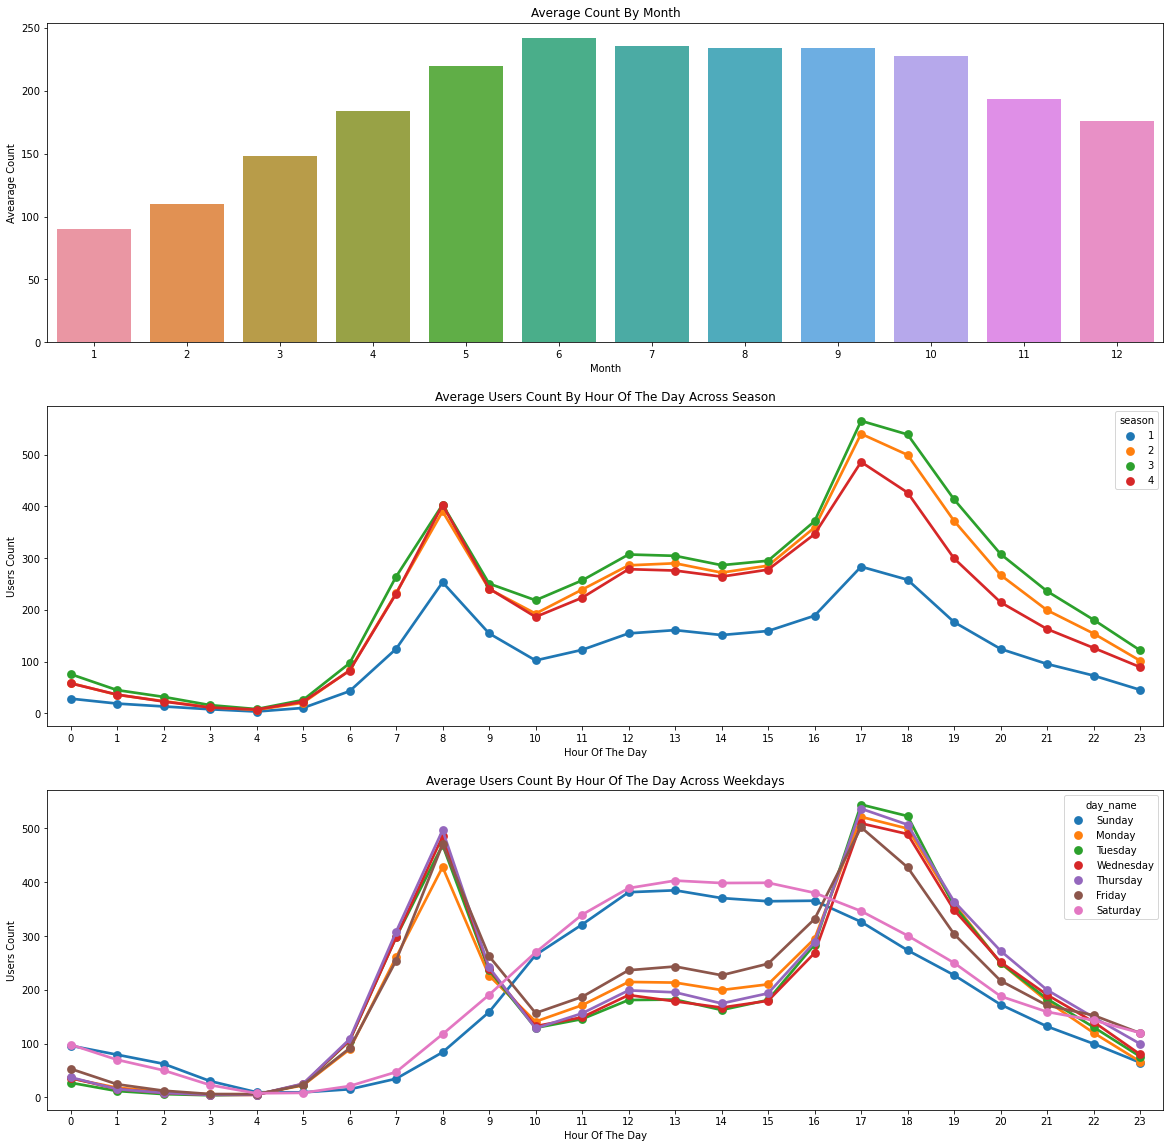

In [13]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)

fig.set_size_inches(20,20)
#sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(df.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(df.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(df.groupby(["hour","day_name"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["day_name"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')


fig.savefig('Output3.png')

## Feature Engineering


In [14]:
## Define X and y

y = df['count']
X = df.loc[:, df.columns != 'count']

In [74]:
X

,atemp,datetime,day,day_name,holiday,hour,humidity,month,season,temp,weather,windspeed,workingday,year
0,14.395,2011-01-01 00:00:00,1,Saturday,0,0,81.0,1,1,9.84,1,8.111355,0,2011
1,13.635,2011-01-01 01:00:00,1,Saturday,0,1,80.0,1,1,9.02,1,7.891327,0,2011
2,13.635,2011-01-01 02:00:00,1,Saturday,0,2,80.0,1,1,9.02,1,7.871294,0,2011
3,14.395,2011-01-01 03:00:00,1,Saturday,0,3,75.0,1,1,9.84,1,8.091858,0,2011
4,14.395,2011-01-01 04:00:00,1,Saturday,0,4,75.0,1,1,9.84,1,7.612339,0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,19.695,2012-12-19 19:00:00,19,Wednesday,0,19,50.0,12,4,15.58,1,26.002700,1,2012
10882,17.425,2012-12-19 20:00:00,19,Wednesday,0,20,57.0,12,4,14.76,1,15.001300,1,2012
10883,15.910,2012-12-19 21:00:00,19,Wednesday,0,21,61.0,12,4,13.94,1,15.001300,1,2012
10884,17.425,2012-12-19 22:00:00,19,Wednesday,0,22,61.0,12,4,13.94,1,6.003200,1,2012


In [15]:
## Define Root Mean Squared Log Error

def RMSLE(y_test,pred):
    y_test=np.array(y_test)
    pred=np.array(pred)
    y_test[y_test<0]=0
    pred[pred<0]=0
    return -np.sqrt(mean_squared_log_error(y_test,pred))
RMSLE_scorer = make_scorer(RMSLE,greater_is_better=False)

In [16]:
trans = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ['season', 'day_name', 'month', 'weather', 'holiday', 'hour' ]),    
    (StandardScaler(), ['temp', 'humidity', 'windspeed']),
    #(KBinsDiscretizer(n_bins=6, strategy='uniform'), ['hour']),
    #(KBinsDiscretizer(n_bins=6, strategy='uniform'), ['month'])

    
)

## Random Forest model 

In [17]:
model_pipeline_rf = make_pipeline(
    trans, 
    PolynomialFeatures(degree=2,
                     interaction_only=True,
                     include_bias=False),
      RandomForestRegressor(n_estimators=100, max_depth=5)
)

In [18]:
from sklearn.model_selection import GridSearchCV

model_pipeline_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'polynomialfeatures', 'randomforestregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', '

In [19]:
grid_rf = {
    'polynomialfeatures__degree' : [1,2],
    'randomforestregressor__n_estimators':[100,200,300],
    'randomforestregressor__max_depth' : [10,15,20,25,30],
   # 'randomforestregressor__min_samples_split':[2,4,8,16]
}

In [20]:
from sklearn.model_selection import RandomizedSearchCV

cv_rf = RandomizedSearchCV(
    estimator=model_pipeline_rf,
    param_distributions=grid_rf,
    scoring=RMSLE_scorer, # use your own scorer with the make_scorer function
    cv=5, return_train_score=True
)

In [21]:
cv_rf.fit(X, y)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['season',
                                                                                'day_name',
                                                                                'month',
                                                                                'weather',
                                                                                'holiday',
                                                                                'hour']),
                                           

In [22]:
y_pred_rf = cv_rf.predict(X)

RMSLE(y, y_pred_rf)

-1.014482123208715

In [23]:
cv_rf_results = pd.DataFrame(cv_rf.cv_results_)
cv_rf_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_randomforestregressor__n_estimators',
       'param_randomforestregressor__max_depth',
       'param_polynomialfeatures__degree', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [24]:
cv_rf_results['difference_in_score']=cv_rf_results['mean_test_score']-cv_rf_results['mean_train_score']

In [25]:
cv_rf_results[[
    'rank_test_score',
    'mean_test_score',     
    'mean_train_score',
    'difference_in_score',
    'param_randomforestregressor__n_estimators',
    'param_randomforestregressor__max_depth',
    'param_polynomialfeatures__degree']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,mean_train_score,difference_in_score,param_randomforestregressor__n_estimators,param_randomforestregressor__max_depth,param_polynomialfeatures__degree
2,1,1.070132,0.983247,0.086885,100,10,1
7,2,1.069796,0.981856,0.087940,300,10,1
1,3,0.801451,0.683323,0.118127,300,15,2
6,4,0.799413,0.648681,0.150732,100,15,1
5,5,0.699409,0.494866,0.204543,100,20,2
8,6,0.691964,0.490914,0.201050,200,20,2
0,7,0.659453,0.318501,0.340952,100,25,1
9,8,0.657681,0.317509,0.340172,200,25,1
3,9,0.651427,0.271044,0.380383,200,30,1
4,10,0.645164,0.319610,0.325553,200,30,2


## Final Random forest


In [27]:
trans_rf_final = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ['season', 'day_name', 'month', 'weather', 'hour' ]),    
    (StandardScaler(), ['temp', 'humidity', 'windspeed']),
   # (KBinsDiscretizer(n_bins=2, strategy='uniform'), ['hour']),
    #(KBinsDiscretizer(n_bins=6, strategy='uniform'), ['month'])

    
)

In [39]:
## Final Random forest with n_estimators=200, max_depth=30 and PolynomialFeatures=2

model_pipeline_rf_final = make_pipeline(
    trans_rf_final, 
    PolynomialFeatures(degree=2,
                     interaction_only=True,
                     include_bias=False),
      RandomForestRegressor(n_estimators=200, max_depth=30)
)

In [37]:
df_fit_rf_final= model_pipeline_rf_final.fit(X, y)
y_pred_rf_final = model_pipeline_rf_final.predict(X)
y_pred_rf_final.mean()

191.4928768118774

In [38]:
RMSLE(y, y_pred_rf_final)

-0.32580816506406574

## Poisson Regression model


In [40]:
from sklearn.linear_model import PoissonRegressor

model_pipeline_pr = make_pipeline(
    trans, 
    PolynomialFeatures(degree=2,
                     interaction_only=False,
                     include_bias=False),
     PoissonRegressor(alpha=0, max_iter=3000)
)

In [32]:
model_pipeline_pr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'polynomialfeatures', 'poissonregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'poissonregressor__alpha', 'poissonregressor__fit_intercept', 'poissonregressor__max_iter', 'poissonregressor__tol

In [41]:
grid_pr = {
    'polynomialfeatures__degree' : [1,2],
    'poissonregressor__alpha' : [ .01, .1, 0, .5],
    'poissonregressor__max_iter': [2000, 3000, 4000]
}

In [42]:
## We do a Randomized grid search to get a faster result

from sklearn.model_selection import RandomizedSearchCV


cv_pr = RandomizedSearchCV(
    estimator=model_pipeline_pr,
    param_distributions=grid_pr,
    scoring=RMSLE_scorer, # use your own scorer with the make_scorer function
    cv=5, return_train_score=True
)

In [43]:
cv_pr.fit(X, y)
cv_pr_results = pd.DataFrame(cv_pr.cv_results_)

In [44]:
cv_pr_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_polynomialfeatures__degree', 'param_poissonregressor__max_iter',
       'param_poissonregressor__alpha', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [45]:
cv_pr_results['difference_in_score']=cv_pr_results['mean_test_score']-cv_pr_results['mean_train_score']

In [46]:
cv_pr_results[[
    'rank_test_score',
    'mean_test_score',    
    'mean_train_score',
    'difference_in_score',
    'param_poissonregressor__max_iter',
    'param_poissonregressor__alpha',
    'param_polynomialfeatures__degree']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,mean_train_score,difference_in_score,param_poissonregressor__max_iter,param_poissonregressor__alpha,param_polynomialfeatures__degree
4,1,0.865142,0.797633,0.067509,2000,0.5,1
5,1,0.865142,0.797633,0.067509,4000,0.5,1
8,3,0.777916,0.692131,0.085785,2000,0.1,1
9,3,0.777916,0.692131,0.085785,3000,0.1,1
2,5,0.754784,0.661443,0.093341,2000,0.01,1
1,6,0.752896,0.658598,0.094298,2000,0,1
3,7,0.567058,0.419088,0.147969,4000,0.1,2
0,8,0.528853,0.350720,0.178133,4000,0.01,2
7,8,0.528853,0.350720,0.178133,2000,0.01,2
6,10,0.528060,0.343032,0.185028,3000,0,2


## Final Poisson 


In [50]:
trans_final_pr = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ['season', 'day_name', 'month', 'weather', 'hour' ]),    
    (StandardScaler(), ['temp', 'humidity', 'windspeed']),
       
)


In [51]:
## Final Poisson with alpha=0, max_iter=3000 and PolynomialFeatures=2

model_pipeline_pr_final = make_pipeline(
    trans_final_pr, 
    PolynomialFeatures(degree=2,
                     interaction_only=False,
                     include_bias=False),
     PoissonRegressor(alpha=0, max_iter=3000)
)

In [52]:
df_fit_pr_final= model_pipeline_pr_final.fit(X, y)
y_pred_pr_final = model_pipeline_pr_final.predict(X)
y_pred_pr_final.mean()

191.57416036138798

In [53]:
RMSLE(y, y_pred_pr_final)

-0.37503521609579776

## Load test data

In [115]:
## Loading test data

df_test = pd.read_csv('test.csv', parse_dates = True)


In [116]:
ts_Kaggle = pd.to_datetime(df_test['datetime'])

df_test['year']= ts_Kaggle.dt.year
df_test['month']= ts_Kaggle.dt.month
df_test['day']= ts_Kaggle.dt.day
df_test['hour']=ts_Kaggle.dt.hour
df_test['day_name']=ts_Kaggle.dt.day_name()
#df_test = df_test.drop(['datetime'], axis=1)

X_Kaggle = df_test
X_Kaggle.head(5)





,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,day_name
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,Thursday
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,Thursday
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,Thursday
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,Thursday
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,Thursday


In [117]:
# Dealing with number of zeroes in windspeed

df_test[df_test['windspeed'] == 0].shape


(867, 14)

In [118]:
## filling up the zero values via Random Forest

df_test_windspeed_0 = df_test[df_test['windspeed'] == 0]
df_test_windspeed_not_0 = df_test[df_test['windspeed'] != 0]

columns_for_windspeed = ['holiday', 'season', 'workingday', 'month', 'hour', 'year', 'day', 'temp', 'humidity']

from sklearn.ensemble import RandomForestRegressor
rf_windspeed_test = RandomForestRegressor().fit(df_test_windspeed_not_0[columns_for_windspeed], df_test_windspeed_not_0['windspeed'])
df_test_windspeed_0['windspeed'] = rf_windspeed.predict(df_test_windspeed_0[columns_for_windspeed])

df_test = df_test_windspeed_0.append(df_test_windspeed_not_0, sort = 'datetime')

/home/aprameyo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [119]:
df_test[df_test['windspeed'] == 0].shape


(0, 14)

In [121]:
X_Kaggle = df_test
X_Kaggle.head(5)

,atemp,datetime,day,day_name,holiday,hour,humidity,month,season,temp,weather,windspeed,workingday,year
1,13.635,2011-01-20 01:00:00,20,Thursday,0,1,56,1,1,10.66,1,13.389950,1,2011
2,13.635,2011-01-20 02:00:00,20,Thursday,0,2,56,1,1,10.66,1,12.880013,1,2011
12,16.665,2011-01-20 12:00:00,20,Thursday,0,12,42,1,1,12.30,2,22.140619,1,2011
60,8.335,2011-01-22 13:00:00,22,Saturday,0,13,35,1,1,3.28,1,23.450938,0,2011
62,7.575,2011-01-22 15:00:00,22,Saturday,0,15,28,1,1,4.92,1,32.769834,0,2011


In [123]:
predictions = model_pipeline_pr_final.predict(X_Kaggle)


In [125]:
submission = pd.DataFrame({'datetime':X_Kaggle['datetime'],'count':predictions})


submission['count'] =  np.where(submission['count']<0, 0, submission['count'])

submission.loc[submission['count']==0]

,datetime,count


In [127]:
filename = 'Bike_Predictions_Final.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: Bike_Predictions_Final.csv
